# single-cell Progeny Production analysis
This notebook provides a central place to integrate and analyze transcriptome and progeny production data.

## Notebook setup
First give paths and values to all variables. Then, load in data.

Python imports:

In [1]:
from IPython.display import display

from dms_variants.constants import CBPALETTE

import numpy

import pandas as pd

import plotnine as p9

import scanpy

import scipy

import statsmodels.stats.multitest

Input data paths. Currently hardcoded.

In [2]:
matrix = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/matrix.mtx'
cell_barcodes = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/barcodes.tsv'
features = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/features.tsv'
viral_tag_by_cell_csv = 'results/viral_tags_bcs_in_cells/scProgenyProduction_trial3_cell_barcodes_with_viral_tags.csv.gz'
viral_bc_background_freq_csv = 'results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_background_freq.csv.gz'
viral_bc_in_progeny_freq_csv = 'results/viral_progeny/scProgenyProduction_trial3_viral_bc_in_progeny_freq.csv.gz'

Global variables for this notebook:

In [3]:
expt = 'scProgenyProduction_trial3'
plot = 'results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_correlations.pdf'
viral_genes = ['fluPB2', 'fluPB1', 'fluPA', 'fluHA', 'fluNA', 'fluNP', 'fluM', 'fluNS']
barcoded_viral_genes = ['fluHA', 'fluNA']

Style parameters. *N.b.* `CBPALETTE` is defined in imports above.

In [4]:
p9.theme_set(p9.theme_classic())

### Load data

**Transcriptome** viral barcode frequencies:

In [5]:
transcriptome_viral_bc_freqs = pd.read_csv(viral_bc_background_freq_csv)
assert set(transcriptome_viral_bc_freqs['gene']) == set(barcoded_viral_genes), \
       "Barcoded genes in barcode counts do not match expectation."
display(transcriptome_viral_bc_freqs)

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0,0.000000,False
1,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0,0.000000,False
2,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0,0.000000,False
3,AAACGAAGTACTTCCC,True,both,0.448272,fluHA,NaN,0,0.000000,False
4,AAACGAAGTAGACGTG,True,wt,0.040116,fluHA,AAGTAAGCGACATGAG,93,0.001731,True
...,...,...,...,...,...,...,...,...,...
9185,TTTGATCTCCCGTTCA,False,none,0.000109,fluNA,NaN,0,0.000000,False
9186,TTTGATCTCGCATTGA,True,wt,0.063156,fluNA,NaN,0,0.000000,False
9187,TTTGGAGAGTTGCCTA,False,none,0.000070,fluNA,NaN,0,0.000000,False
9188,TTTGGAGGTATCGTTG,True,wt,0.024534,fluNA,ACATCTTATTTACACG,15,0.000230,True


**Progeny** viral barcode frequencies:

*N.b. For now just work with supernatant data. Remove second_infection frequencies.*

In [6]:
progeny_viral_bc_freqs = pd.read_csv(viral_bc_in_progeny_freq_csv)
assert set(progeny_viral_bc_freqs['gene']) == set(barcoded_viral_genes), \
       "Barcoded genes in barcode counts do not match expectation."
progeny_viral_bc_freqs = (progeny_viral_bc_freqs
                          .rename(columns={'barcode': 'viral_barcode',
                                           'tag': 'infecting_viral_tag',
                                           'mean_freq': 'freq_sup',
                                           'mean_count': 'count_sup'}))
progeny_viral_bc_freqs = (progeny_viral_bc_freqs
                          .query('source == "supernatant"'))
progeny_viral_bc_freqs = progeny_viral_bc_freqs.drop(columns = 'source')
display(progeny_viral_bc_freqs)

,infecting_viral_tag,gene,viral_barcode,count_sup,freq_sup
0,syn,fluHA,AAAAAAGCACGAGCAG,0.5,2.507618e-07
1,syn,fluHA,AAAAAATCCTTCAGCA,0.5,2.574453e-07
2,syn,fluHA,AAAAAATGGCGACGCT,0.5,2.574453e-07
3,syn,fluHA,AAAAAATTGGTTTACT,0.5,2.574453e-07
4,syn,fluHA,AAAAACACTCACAAGT,0.5,2.574453e-07
...,...,...,...,...,...
61196,wt,fluNA,TTTTTCCCTTACATAT,0.5,2.399886e-07
61197,wt,fluNA,TTTTTCTTACGATCAC,0.5,2.399886e-07
61198,wt,fluNA,TTTTTCTTCGAGATAG,6.0,3.062051e-06
61199,wt,fluNA,TTTTTGGGATCATTGC,2.0,1.142142e-06


Cell-gene matrix:

In [7]:
adata = scanpy.read_mtx(matrix)
adata.var = pd.read_csv(cell_barcodes,
                        names=['cell_barcode'])
adata.obs = pd.read_csv(features,
                        sep='\t',
                        names=['ensemble_id', 'gene', 'feature_type'])

print(f"Read cell-gene matrix of {adata.n_vars} cells and {adata.n_obs} genes")

assert set(viral_genes).issubset(set(adata.obs['gene'])), 'lack viral genes'

Read cell-gene matrix of 3368 cells and 30959 genes


### Cross-check data
Use assert statements to ensure that that the number and identity of cell barcodes is identical between data sources.

In [8]:
assert transcriptome_viral_bc_freqs['cell_barcode'].nunique() == \
       adata.var['cell_barcode'].nunique(), \
       "Number of cells discrepancy"

assert set(transcriptome_viral_bc_freqs['cell_barcode']) == \
       set(adata.var['cell_barcode']), \
       "Cell barcodes do not match between data sources"

### Plot raw data
Plot data from each source without filtering or processing. This is mostly for exploration and transparency.

#### Viral barcode transcription

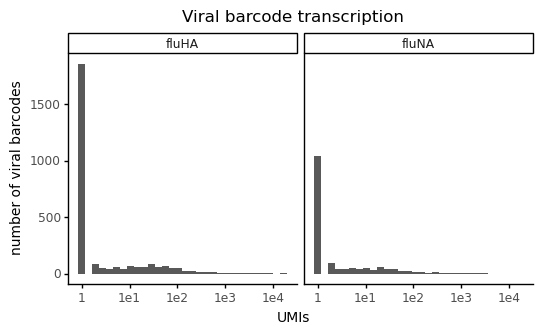

<ggplot: (8748938416607)>

In [9]:
fig = (p9.ggplot((transcriptome_viral_bc_freqs
                  .query('viral_barcode.notnull()',
                         engine='python')),
                 p9.aes(x='viral_bc_UMIs')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcode transcription') +
       p9.labs(x='UMIs',
               y='number of viral barcodes') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

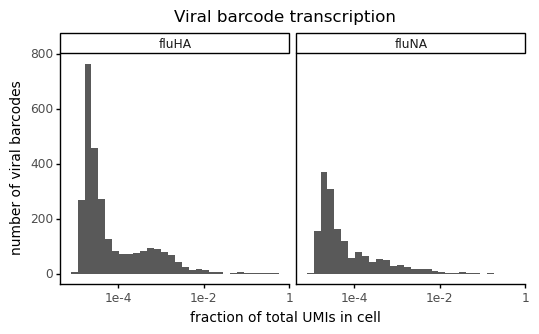

<ggplot: (8748605311501)>

In [10]:
fig = (p9.ggplot((transcriptome_viral_bc_freqs
                  .query('viral_barcode.notnull()',
                         engine='python')),
                 p9.aes(x='frac_viral_bc_UMIs')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcode transcription') +
       p9.labs(x='fraction of total UMIs in cell',
               y='number of viral barcodes') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

#### Progeny production: supernatant

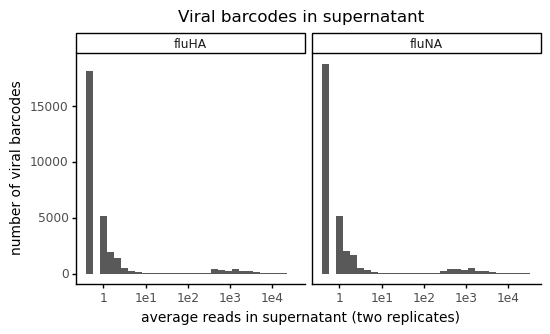

<ggplot: (8748605253021)>

In [11]:
fig = (p9.ggplot(progeny_viral_bc_freqs,
                 p9.aes(x='count_sup')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcodes in supernatant') +
       p9.labs(x='average reads in supernatant (two replicates)',
               y='number of viral barcodes') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

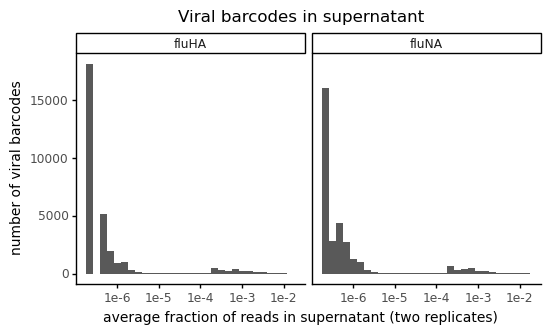

<ggplot: (8748605176643)>

In [12]:
fig = (p9.ggplot(progeny_viral_bc_freqs,
                 p9.aes(x='freq_sup')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcodes in supernatant') +
       p9.labs(x='average fraction of reads in supernatant (two replicates)',
               y='number of viral barcodes') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

### Process data
Next, I will merge the data into a few useable dataframes. I will perform calculations on these data that will help us visualize technical error and filter.

#### Merge all viral barcode data into a central dataframe called `viral_bc_freqs`

Structure of the final dataframe should be as follows:
1. Cell barcode
2. Infected
3. Infecting viral tag
4. Gene
5. Viral barcode
6. Count in the transcriptome (`viral_bc_UMIs`)
7. Frequency in transcriptome (`frac_viral_bc_UMIs`)
8. Count in the supernatant sequencing (`count_sup`)
9. Frequency in supernatant sequencing (`freq_sup`)

In [13]:
viral_bc_freqs = pd.merge(
    left=transcriptome_viral_bc_freqs,
    right=progeny_viral_bc_freqs,
    how='outer',
    on=['viral_barcode', 'gene', 'infecting_viral_tag'])

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,count_sup,freq_sup
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,NaN,NaN
1,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,NaN,NaN
2,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,NaN,NaN
3,AAACGCTCAAATGATG,False,none,0.000107,fluHA,NaN,0.0,0.0,False,NaN,NaN
4,AAACGCTCATGGACAG,False,none,0.000119,fluHA,NaN,0.0,0.0,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
70011,NaN,NaN,wt,NaN,fluNA,TTTTTCCCTTACATAT,NaN,NaN,NaN,0.5,2.399886e-07
70012,NaN,NaN,wt,NaN,fluNA,TTTTTCTTACGATCAC,NaN,NaN,NaN,0.5,2.399886e-07
70013,NaN,NaN,wt,NaN,fluNA,TTTTTCTTCGAGATAG,NaN,NaN,NaN,6.0,3.062051e-06
70014,NaN,NaN,wt,NaN,fluNA,TTTTTGGGATCATTGC,NaN,NaN,NaN,2.0,1.142142e-06


Fill `NA` values in supernatant with `0`. It is meaningful if a viral barcode is seen in the transcriptome but absent from the supernatant; no progeny was produced by that infected cell.

In [14]:
viral_bc_freqs[['count_sup', 'freq_sup']] = (
    viral_bc_freqs[['count_sup', 'freq_sup']]
    .fillna(0)
)

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,count_sup,freq_sup
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00
1,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00
2,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00
3,AAACGCTCAAATGATG,False,none,0.000107,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00
4,AAACGCTCATGGACAG,False,none,0.000119,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
70011,NaN,NaN,wt,NaN,fluNA,TTTTTCCCTTACATAT,NaN,NaN,NaN,0.5,2.399886e-07
70012,NaN,NaN,wt,NaN,fluNA,TTTTTCTTACGATCAC,NaN,NaN,NaN,0.5,2.399886e-07
70013,NaN,NaN,wt,NaN,fluNA,TTTTTCTTCGAGATAG,NaN,NaN,NaN,6.0,3.062051e-06
70014,NaN,NaN,wt,NaN,fluNA,TTTTTGGGATCATTGC,NaN,NaN,NaN,2.0,1.142142e-06


#### Raw correlation of viral transcription and progeny production
Plot raw data:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


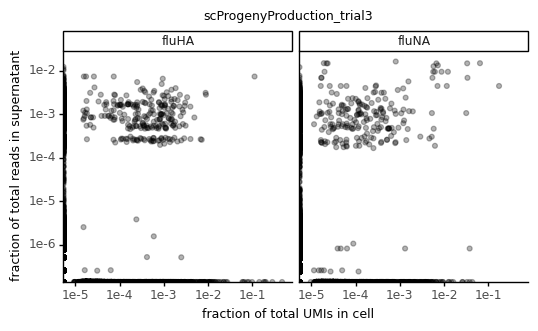

<ggplot: (8748264318260)>

In [25]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_sup')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

#### Viral barcode rank in cell
I will rank each viral barcode in each cell-gene. I will see what fraction of all viral barcode UMIs each viral barcode accounts for.

To do this, I will:
* Group viral barcodes by cell-gene
* Sum fraction of cell UMIs that are assigned to **significant** viral barcodes in that cell-gene
* Rank only viral barcodes **that are significant above uninfected background**

Sum all **significant** viral bc freqs for each cell-gene:

In [17]:
viral_bc_freqs = (
    viral_bc_freqs
    .assign(
        cell_total_frac_viral_bc_UMIs=lambda x: x
                                                .query('reject_uninfected == True')
                                                .groupby(['cell_barcode',
                                                          'gene'])
                                                ['frac_viral_bc_UMIs']
                                                .transform('sum')))

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,count_sup,freq_sup,n_cell_bc,cell_total_frac_viral_bc_UMIs
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,NaN,NaN
1,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,NaN,NaN
2,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,NaN,NaN
3,AAACGCTCAAATGATG,False,none,0.000107,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,NaN,NaN
4,AAACGCTCATGGACAG,False,none,0.000119,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70011,NaN,NaN,wt,NaN,fluNA,TTTTTCCCTTACATAT,NaN,NaN,NaN,0.5,2.399886e-07,NaN,NaN
70012,NaN,NaN,wt,NaN,fluNA,TTTTTCTTACGATCAC,NaN,NaN,NaN,0.5,2.399886e-07,NaN,NaN
70013,NaN,NaN,wt,NaN,fluNA,TTTTTCTTCGAGATAG,NaN,NaN,NaN,6.0,3.062051e-06,NaN,NaN
70014,NaN,NaN,wt,NaN,fluNA,TTTTTGGGATCATTGC,NaN,NaN,NaN,2.0,1.142142e-06,NaN,NaN


Calculate proportion of total significant viral bc UMI fraction in cell-gene that is derived from each significant viral bc:

In [19]:
viral_bc_freqs = (
    viral_bc_freqs
    .assign(
        prop_cell_viral_bc_UMIs=lambda x: x['frac_viral_bc_UMIs'] /
                                          x['cell_total_frac_viral_bc_UMIs']))

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,count_sup,freq_sup,n_cell_bc,cell_total_frac_viral_bc_UMIs,prop_cell_viral_bc_UMIs
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,NaN,NaN,NaN
1,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,NaN,NaN,NaN
2,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,NaN,NaN,NaN
3,AAACGCTCAAATGATG,False,none,0.000107,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,NaN,NaN,NaN
4,AAACGCTCATGGACAG,False,none,0.000119,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70011,NaN,NaN,wt,NaN,fluNA,TTTTTCCCTTACATAT,NaN,NaN,NaN,0.5,2.399886e-07,NaN,NaN,NaN
70012,NaN,NaN,wt,NaN,fluNA,TTTTTCTTACGATCAC,NaN,NaN,NaN,0.5,2.399886e-07,NaN,NaN,NaN
70013,NaN,NaN,wt,NaN,fluNA,TTTTTCTTCGAGATAG,NaN,NaN,NaN,6.0,3.062051e-06,NaN,NaN,NaN
70014,NaN,NaN,wt,NaN,fluNA,TTTTTGGGATCATTGC,NaN,NaN,NaN,2.0,1.142142e-06,NaN,NaN,NaN


Rank significant viral barcodes within each cell-gene:

In [21]:
viral_bc_freqs = (
    viral_bc_freqs
    .assign(viral_bc_rank=lambda x: x.groupby(['cell_barcode', 'gene'])
                                     ['prop_cell_viral_bc_UMIs']
                                     .rank('dense', ascending=False)))

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,reject_uninfected,count_sup,freq_sup,n_cell_bc,cell_total_frac_viral_bc_UMIs,prop_cell_viral_bc_UMIs,viral_bc_rank
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,NaN,NaN,NaN,NaN
1,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,NaN,NaN,NaN,NaN
2,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,NaN,NaN,NaN,NaN
3,AAACGCTCAAATGATG,False,none,0.000107,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,NaN,NaN,NaN,NaN
4,AAACGCTCATGGACAG,False,none,0.000119,fluHA,NaN,0.0,0.0,False,0.0,0.000000e+00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70011,NaN,NaN,wt,NaN,fluNA,TTTTTCCCTTACATAT,NaN,NaN,NaN,0.5,2.399886e-07,NaN,NaN,NaN,NaN
70012,NaN,NaN,wt,NaN,fluNA,TTTTTCTTACGATCAC,NaN,NaN,NaN,0.5,2.399886e-07,NaN,NaN,NaN,NaN
70013,NaN,NaN,wt,NaN,fluNA,TTTTTCTTCGAGATAG,NaN,NaN,NaN,6.0,3.062051e-06,NaN,NaN,NaN,NaN
70014,NaN,NaN,wt,NaN,fluNA,TTTTTGGGATCATTGC,NaN,NaN,NaN,2.0,1.142142e-06,NaN,NaN,NaN,NaN


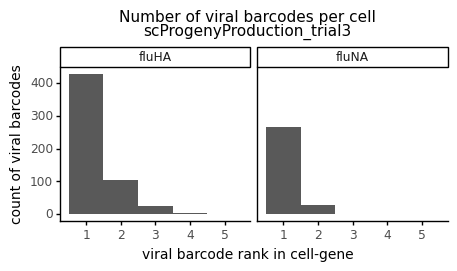

<ggplot: (8748269867716)>

In [22]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('(reject_uninfected == True) and '
                        '(cell_barcode.notna())',
                        engine='python')) +
       p9.geom_histogram(p9.aes(x='viral_bc_rank'),
                         binwidth=1,
                         position='dodge') +
       p9.facet_grid('~gene') +
       p9.ggtitle('Number of viral barcodes per cell\n'
                  f'{expt}') +
       p9.xlab('viral barcode rank in cell-gene') +
       p9.ylab('count of viral barcodes') +
       p9.theme(figure_size=(5, 2),
                plot_title=p9.element_text(size=11),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 69159 rows containing missing values.


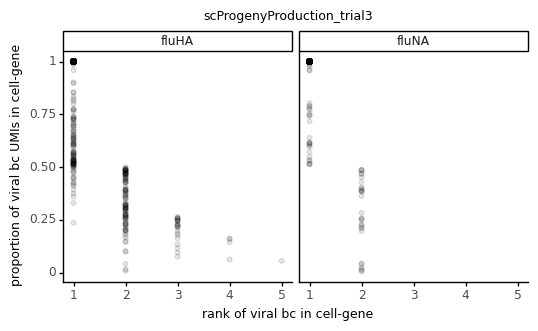

<ggplot: (8748269819642)>

In [23]:
fig = (p9.ggplot((viral_bc_freqs),
                 p9.aes(x='viral_bc_rank',
                        y='prop_cell_viral_bc_UMIs')) +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.labs(x='rank of viral bc in cell-gene',
               y='proportion of viral bc UMIs in cell-gene') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
      p9.scale_color_discrete(guide=False))
display(fig)